In [1]:
import sys
if r'C:\Users\attic\HLS Kelp Detection\tools' not in sys.path:
    sys.path.append(r'C:\Users\attic\HLS Kelp Detection\tools')
import data_tools as dt
import rasterio
import os
import pickle
import numpy as np
from rasterio.errors import RasterioIOError
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import clear_output
import matplotlib.dates as mdates
import re

In [7]:
def convert_df_types(df, col_types=None):
    if col_types is None:
        col_types = {
            'kelp_pixels': int,
            'day_num': float,
            'mesma': float,
            'clouds': float,
            'cloud_correction_factor': float,
            'date': 'datetime'
        }
    for col, dtype in col_types.items():
        if dtype == 'datetime':
            df[col] = [datetime.strptime(date_str[:26], "%Y-%m-%dT%H:%M:%S.%f") for date_str in df[col]]
        else:
            df[col] = df[col].astype(dtype)
    return df



In [3]:
version =4
path = rf'C:\Users\attic\HLS Kelp Detection\processed imagery\tiles\10UCU'
filenames = os.listdir(path)
#filenames.remove('kelp_map.tif')
#pairs = dt.group_by_date(filenames, max_days=3, max_pair_size=2)
#print(f'Pairs found: {len(pairs)}')
tile = '10UCU'

In [ ]:
kelp_map = dt.generate_binary_kelp_map(tile, version=0, save=True, binary_threshold=10)
plt.figure()
plt.imshow(kelp_map)
plt.show()

In [5]:
kelp_image =dt.load_processed_img(r'C:\Users\attic\HLS Kelp Detection\processed imagery\tiles\10UCU', 'kelp_map.tif', bands=[1], just_data=True)
files = set(os.listdir(path))
files.discard('kelp_map.tif')
files = list(files)
sorted_files = dt.sort_filenames_by_date(files)
image_data_list =[]
image_data_list_l30 = []
for i,file in enumerate(sorted_files):
    packet = dt.get_image_pixel_sums(path,file,crop=False, bands=[1,2],kelp_map=kelp_image, tide_current=False)
    if packet is not None:
        image_data_list.append(packet)
        if dt.get_sensor(file) == 'L30':
            image_data_list_l30.append(packet)
    clear_output()
    print(f'{i}/{len(sorted_files)}')
image_data_list = np.stack(image_data_list)
image_data_list_l30= np.stack(image_data_list_l30)

274/275


In [8]:
keys = ['file','day_num', 'date', 'mesma', 'kelp_pixels','clouds', 'cloud_correction_factor']
ts_df = pd.DataFrame(image_data_list, columns=keys)
ts_df = convert_df_types(ts_df)

ts_df_l30 = pd.DataFrame(image_data_list_l30, columns=keys)
ts_df_l30 = convert_df_types(ts_df_l30)
#ts_df_l30 = convert_df_types(ts_df)
# ts_df['kelp_pixels'] = ts_df['kelp_pixels'].astype(int)
# ts_df['day_num'] = ts_df['day_num'].astype(float)
# ts_df['mesma'] = ts_df['mesma'].astype(float)
# ts_df['tide'] = ts_df['tide'].astype(float)
# ts_df['clouds'] = ts_df['clouds'].astype(float)
# ts_df['current'] = ts_df['current'].astype(float)
# ts_df['cloud_correction_factor'] = ts_df['cloud_correction_factor'].astype(float)
# ts_df['date'] = [datetime.strptime(date_str[:26], "%Y-%m-%dT%H:%M:%S.%f") for date_str in ts_df['date']]


In [19]:
ts_df_filtered = ts_df[(ts_df['mesma'] <= 2000000) ]
ts_df_filtered = ts_df_filtered[(ts_df_filtered['cloud_correction_factor'] <1.5)]
ts_df_l30_filtered = ts_df_l30[(ts_df_l30['mesma'] <= 2000000) ]
ts_df_l30_filtered = ts_df_l30_filtered[(ts_df_l30_filtered['cloud_correction_factor'] <1.5)]

9052.32


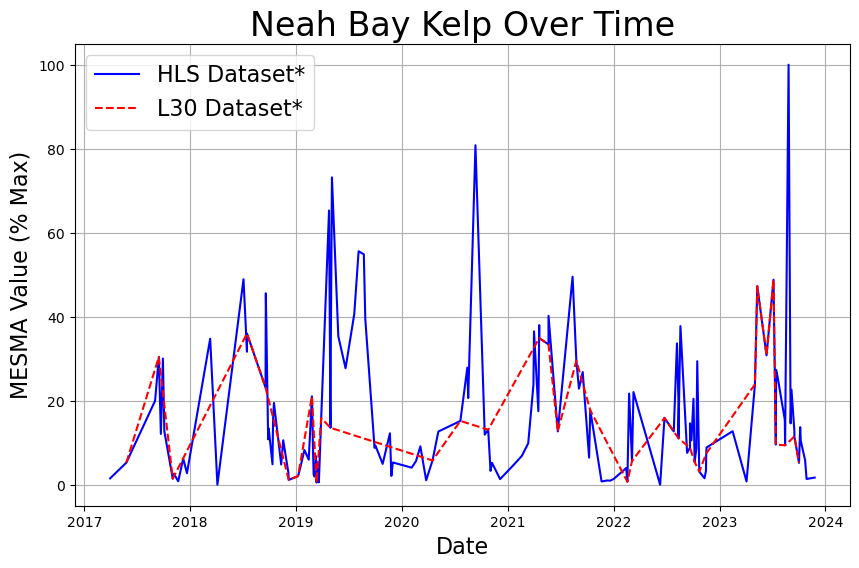

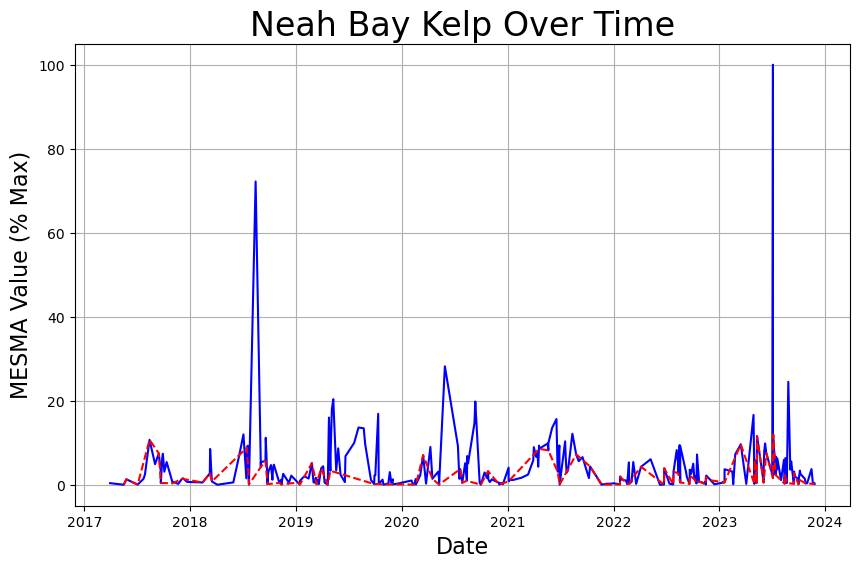

: 

In [21]:
plt.figure(figsize=(10, 6))
max_val = float(np.max(ts_df_filtered['mesma']) / 100)
print(max_val)

plt.plot(ts_df_filtered['date'], (ts_df_filtered['mesma']/max_val), color='blue', label='HLS Dataset*')
plt.plot(ts_df_l30_filtered['date'], (ts_df_l30_filtered['mesma']/max_val), color='red', linestyle='--', label='L30 Dataset*')
plt.xlabel('Date', fontsize=16)
plt.ylabel('MESMA Value (% Max)', fontsize=16)
plt.title('Neah Bay Kelp Over Time', fontsize=24)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()


plt.figure(figsize=(10, 6))
max_val = float(np.max(ts_df['mesma']) / 100)
plt.plot(ts_df['date'], (ts_df['mesma']/max_val), color='blue', label='Full Dataset')
plt.plot(ts_df_l30['date'], (ts_df_l30['mesma']/max_val), color='red', linestyle='--', label='L30 Dataset*')
#plt.plot(ts_df_l30['date'], (ts_df_l30['mesma']/max_val), color='red', linestyle='--', label='L30 Data')
plt.xlabel('Date', fontsize=16)
plt.ylabel('MESMA Value (% Max)', fontsize=16)
plt.title('Neah Bay Kelp Over Time', fontsize=24)
plt.grid(True)
#plt.legend(fontsize=16)
plt.show()

In [ ]:
high_data = []
low_data =[]
kelp_map = dt.load_processed_img("H:\HLS_data\imagery\Isla_vista_kelp\processed_v4", 'kelp_map.tif', bands=[1], crop=True, just_data=True)
kelp_map = kelp_map[0]
for pair in pairs:
    files = pair[1]
    data_1 = dt.get_image_pixel_sums(path,files[0],crop=True,kelp_map=kelp_image)
    data_2 = dt.get_image_pixel_sums(path,files[1],crop=True,kelp_map=kelp_image)
    if data_1 is not None and data_2 is not None:
        if int(data_1[3]) > int(data_2[3]):
           high_data.append(data_1)
           low_data.append(data_2)
        else:
            high_data.append(data_2)
            low_data.append(data_1)

high_data =np.stack(high_data)
low_data = np.stack(low_data)
high_df = pd.DataFrame(high_data, columns=keys)
high_df = convert_df_types(high_df)

low_df = pd.DataFrame(low_data, columns=keys)
low_df = convert_df_types(low_df)

In [ ]:

low_df_filtered = low_df[(ts_df['mesma'] <= 10000000) ]
high_df_filtered = high_df[(ts_df['mesma'] <= 10000000)]
low_df_filtered = low_df_filtered[(low_df_filtered['cloud_correction_factor'] <1.3) & (high_df_filtered['cloud_correction_factor'] <1.3) ]
high_df_filtered = high_df_filtered[(low_df_filtered['cloud_correction_factor'] <1.3) & (high_df_filtered['cloud_correction_factor'] <1.3) ]



plt.figure(figsize=(10, 6))
max_val = float(np.max(ts_df_filtered['mesma']) / 100)
plt.plot(ts_df_filtered['date'], (ts_df_filtered['mesma']/max_val) ,color='blue', label='Full Dataset', alpha=.25)
plt.scatter(high_df_filtered['date'],(high_df_filtered['mesma']/max_val), color = 'red', label='High Pair Value')
plt.scatter(low_df_filtered['date'],(low_df_filtered['mesma']/max_val), color = 'green', label='Low Pair Value')
plt.xlabel('Date')
plt.ylabel('MESMA Value (% Max)')
plt.title('MESMA Kelp Values Over Time')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(ts_df_filtered['date'], (ts_df_filtered['kelp_pixels']) ,color='blue', label='Full Dataset', alpha=.25)
plt.scatter(high_df_filtered['date'],(high_df_filtered['kelp_pixels']), color = 'red', label='High Pair Value')
plt.scatter(low_df_filtered['date'],(low_df_filtered['kelp_pixels']), color = 'green', label='Low Pair Value')
plt.xlabel('Date')
plt.ylabel('Kelp Pixels Count')
plt.title('Kelp Pixel Detection Variance')
plt.grid(True)
plt.legend()
plt.show()